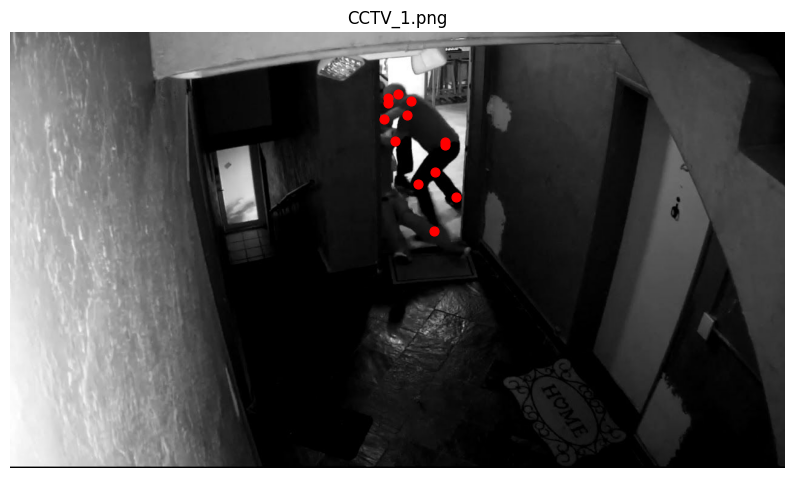

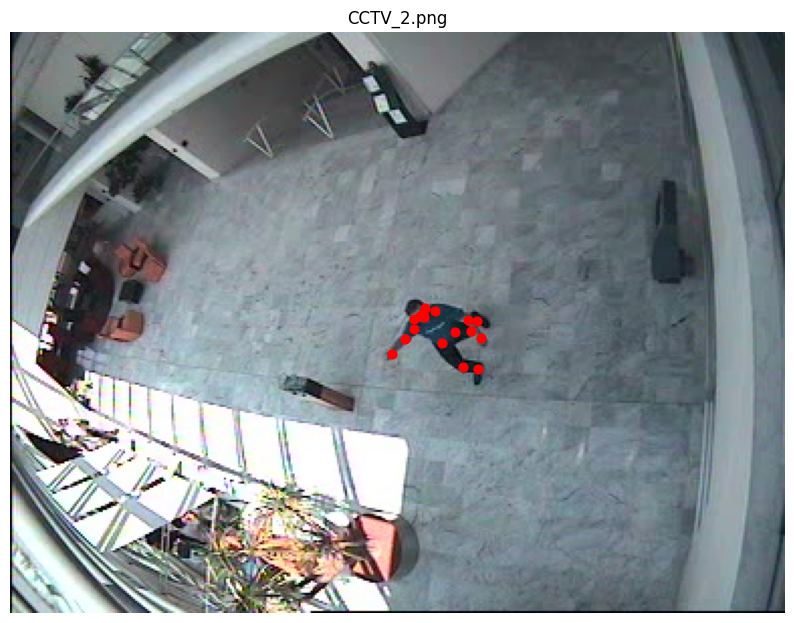

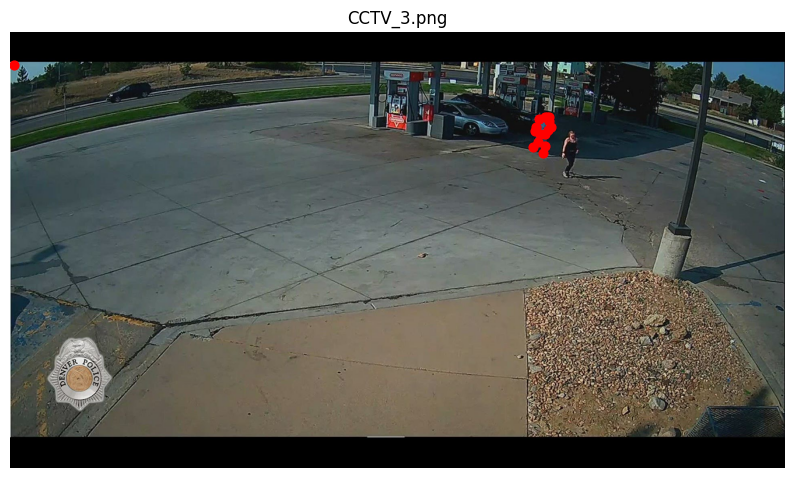

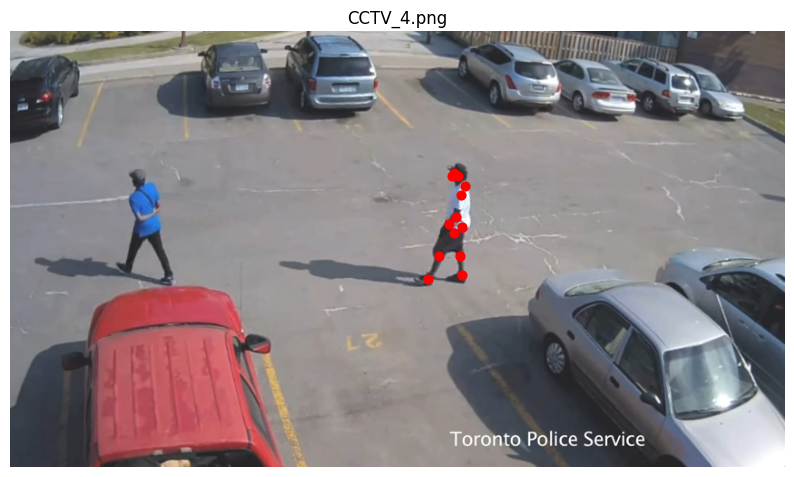

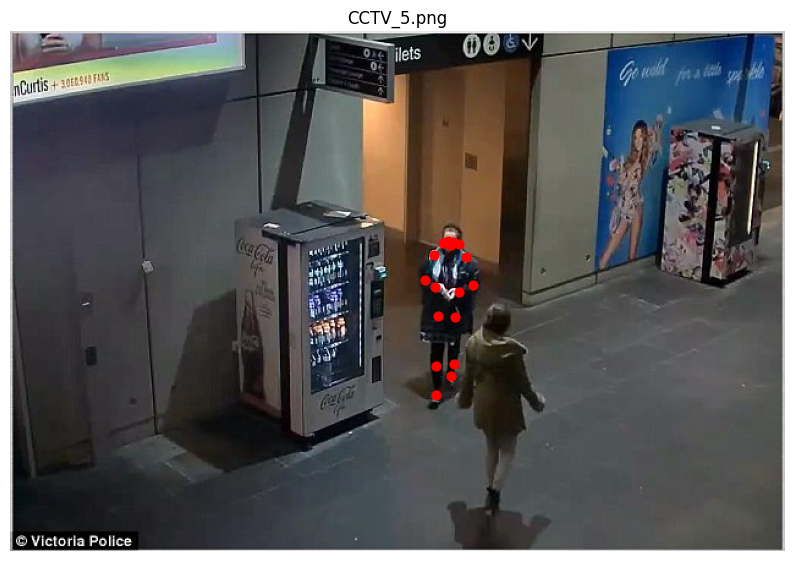

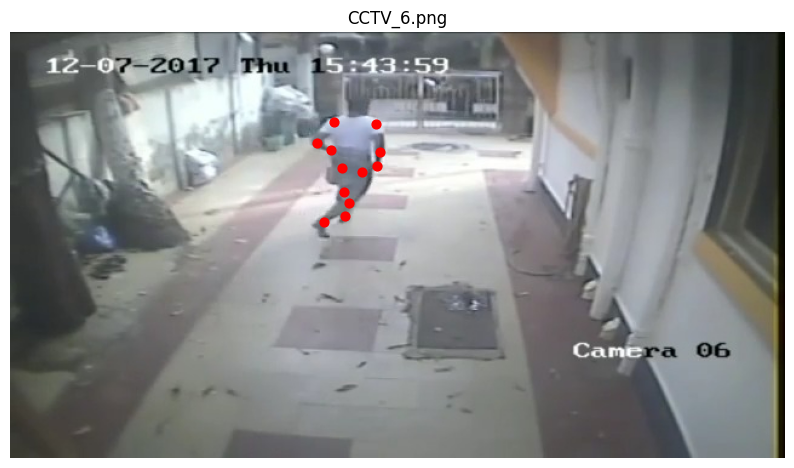

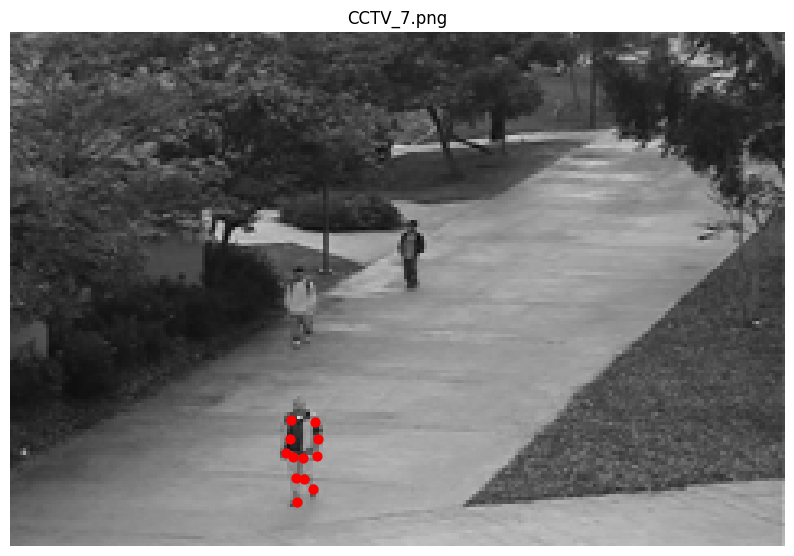

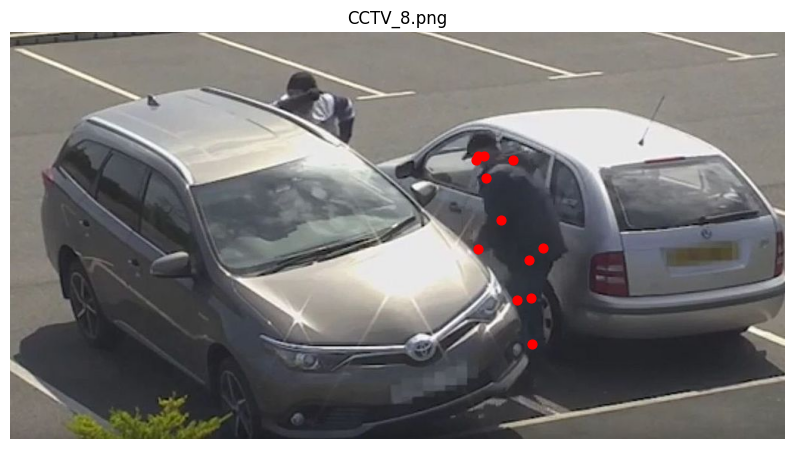

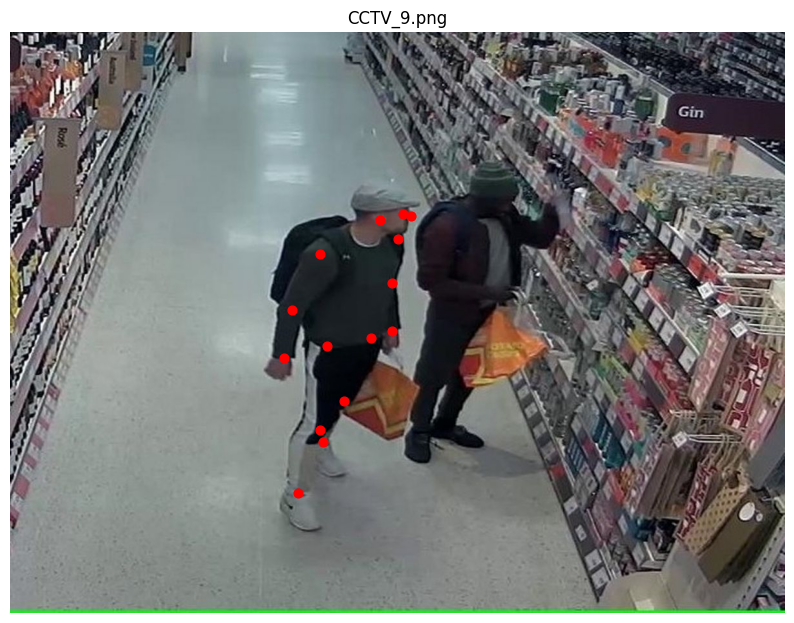

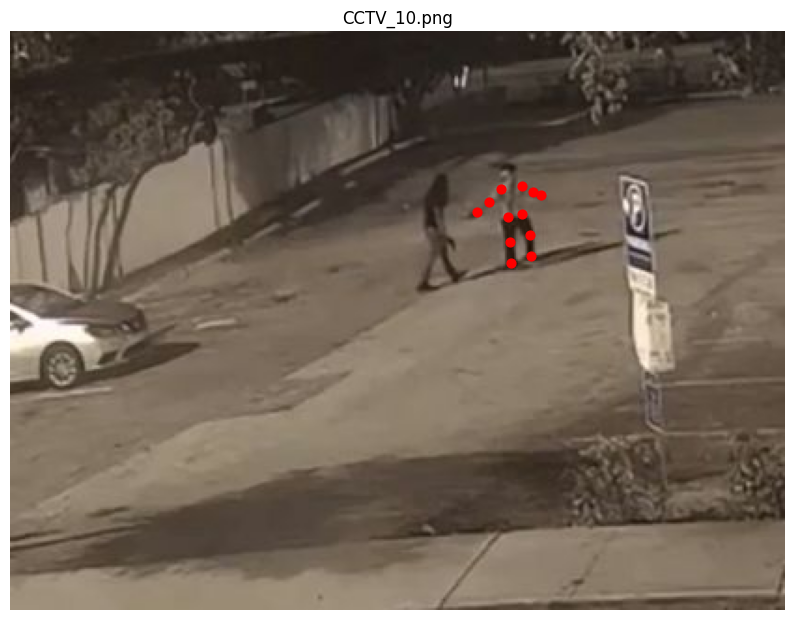

In [2]:
import json
import os
import cv2
import matplotlib.pyplot as plt

# Load the JSON data
with open('/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json', 'r') as f:
    data = json.load(f)

# Extract image and annotation data
images = data['images']
annotations = data['annotations']

# Create a dictionary to map image IDs to keypoints
keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in annotations}

# Function to visualize images with keypoints
def visualize_images_with_keypoints(images, keypoints_dict, num_images=10):
    for i in range(min(num_images, len(images))):
        image_info = images[i]
        image_path = os.path.join(path_to_your_images_directory, image_info['file_name'])
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get keypoints for the current image
        keypoints = keypoints_dict.get(image_info['id'], [])
        
        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        
        # Plot keypoints
        for j in range(0, len(keypoints), 3):
            x, y, v = keypoints[j], keypoints[j + 1], keypoints[j + 2]
            if v > 0:  # visibility flag is greater than 0, draw the keypoint
                plt.scatter(x, y, c='red', s=40)
        
        plt.title(image_info['file_name'])
        plt.axis('off')
        plt.show()

# Replace 'path_to_your_images_directory' with the actual path to your images directory
path_to_your_images_directory = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images'

# Visualize images with keypoints
visualize_images_with_keypoints(images, keypoints_dict)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)



In [3]:
import os
import shutil
import random

# Define the paths
source_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images'
train_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/for_model_purpose/train'
val_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/for_model_purpose/val'
test_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/for_model_purpose/test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all image files in the source directory
image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and f.endswith('.png')]

# Shuffle the image files
random.shuffle(image_files)

# Define split sizes
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculate the number of images for each set
total_images = len(image_files)
num_train = int(total_images * train_split)
num_val = int(total_images * val_split)
num_test = total_images - num_train - num_val

# Split the image files
train_files = image_files[:num_train]
val_files = image_files[num_train:num_train + num_val]
test_files = image_files[num_train + num_val:]

# Function to copy files to respective directories
def copy_files(files, dest_dir):
    for file in files:
        src = os.path.join(source_dir, file)
        dst = os.path.join(dest_dir, file)
        shutil.copy2(src, dst)

# Copy the files
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f'Total images: {total_images}')
print(f'Training images: {len(train_files)}')
print(f'Validation images: {len(val_files)}')
print(f'Test images: {len(test_files)}')


Total images: 700
Training images: 560
Validation images: 70
Test images: 70


In [9]:
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights

# Custom dataset class
class KeypointDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.annotations}

        # Pre-check for readable images
        self.valid_images = []
        for img_info in self.images:
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            if os.path.exists(img_path) and cv2.imread(img_path) is not None:
                self.valid_images.append(img_info)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        keypoints = keypoints.reshape(-1)  # Flatten the keypoints array
        return image, keypoints

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
annotations_file = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json'
img_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images'

full_dataset = KeypointDataset(annotations_file, img_dir, transform=data_transforms['train'])
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("This is the device: ", device)

# Load pre-trained ResNet-50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the final layer to output the correct number of keypoints (each keypoint has x, y, v)
num_keypoints = 17  # Number of keypoints
model.fc = nn.Linear(model.fc.in_features, num_keypoints * 3)

model = model.to(device)

# Define Mean Squared Error loss
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and evaluation function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device).float()  # Ensure labels are of type float for MSELoss

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train and evaluate the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Save the best model
torch.save(model.state_dict(), '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/best_model.pth')

# Testing the model
model.eval()
test_loss = 0.0
for inputs, labels in tqdm(dataloaders['test'], desc='Testing'):
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)

    test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(dataloaders['test'].dataset)
print(f'Test Loss: {test_loss:.4f}')


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


This is the device:  cuda:0
Epoch 0/24
----------


train 0:  28%|██▊       | 5/18 [00:05<00:08,  1.47it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 0: 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


train Loss: 110026.5266


val 0: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


val Loss: 8747981604732573858136064.0000

Epoch 1/24
----------


train 1:  56%|█████▌    | 10/18 [00:01<00:01,  7.89it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 1: 100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


train Loss: 59234.0432


val 1: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


val Loss: 10422216.9714

Epoch 2/24
----------


train 2:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 2: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


train Loss: 42012.3703


val 2: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


val Loss: 41050.3951

Epoch 3/24
----------


train 3:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 3: 100%|██████████| 18/18 [00:02<00:00,  7.82it/s]


train Loss: 41903.6342


val 3: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


val Loss: 37250.7888

Epoch 4/24
----------


train 4:  39%|███▉      | 7/18 [00:01<00:01,  8.04it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 4: 100%|██████████| 18/18 [00:02<00:00,  8.37it/s]


train Loss: 39570.7311


val 4: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


val Loss: 39808.0243

Epoch 5/24
----------


train 5:  50%|█████     | 9/18 [00:01<00:01,  8.12it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 5: 100%|██████████| 18/18 [00:02<00:00,  8.05it/s]


train Loss: 40163.3638


val 5: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


val Loss: 38988.9610

Epoch 6/24
----------


train 6:  22%|██▏       | 4/18 [00:00<00:02,  6.68it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 6: 100%|██████████| 18/18 [00:02<00:00,  8.07it/s]


train Loss: 39720.4436


val 6: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


val Loss: 36391.0222

Epoch 7/24
----------


train 7:  56%|█████▌    | 10/18 [00:01<00:01,  7.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 7: 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


train Loss: 39297.7349


val 7: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


val Loss: 36480.5214

Epoch 8/24
----------


train 8:  67%|██████▋   | 12/18 [00:01<00:00,  9.69it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 8: 100%|██████████| 18/18 [00:02<00:00,  7.74it/s]


train Loss: 38953.9349


val 8: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


val Loss: 36454.6425

Epoch 9/24
----------


train 9:  33%|███▎      | 6/18 [00:01<00:02,  5.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 9: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]


train Loss: 38993.9693


val 9: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


val Loss: 36832.9410

Epoch 10/24
----------


train 10:  17%|█▋        | 3/18 [00:00<00:02,  5.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 10: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


train Loss: 38750.4020


val 10: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


val Loss: 36071.3302

Epoch 11/24
----------


train 11:  33%|███▎      | 6/18 [00:01<00:02,  5.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 11: 100%|██████████| 18/18 [00:02<00:00,  7.37it/s]


train Loss: 38906.4587


val 11: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


val Loss: 36708.9440

Epoch 12/24
----------


train 12:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 12: 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


train Loss: 38991.3652


val 12: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


val Loss: 36497.0735

Epoch 13/24
----------


train 13:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 13: 100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


train Loss: 38896.8672


val 13: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


val Loss: 35651.8468

Epoch 14/24
----------


train 14:  33%|███▎      | 6/18 [00:01<00:01,  6.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 14: 100%|██████████| 18/18 [00:02<00:00,  7.67it/s]


train Loss: 38900.5933


val 14: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


val Loss: 36020.8826

Epoch 15/24
----------


train 15:  33%|███▎      | 6/18 [00:01<00:01,  6.30it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 15: 100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


train Loss: 38803.9985


val 15: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


val Loss: 35985.8018

Epoch 16/24
----------


train 16:   6%|▌         | 1/18 [00:00<00:10,  1.69it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 16: 100%|██████████| 18/18 [00:02<00:00,  7.76it/s]


train Loss: 38833.3309


val 16: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


val Loss: 36711.6824

Epoch 17/24
----------


train 17:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 17: 100%|██████████| 18/18 [00:02<00:00,  7.99it/s]


train Loss: 38785.2779


val 17: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


val Loss: 35866.8074

Epoch 18/24
----------


train 18:  17%|█▋        | 3/18 [00:00<00:02,  5.34it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 18: 100%|██████████| 18/18 [00:02<00:00,  7.57it/s]


train Loss: 38859.6583


val 18: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


val Loss: 36453.7044

Epoch 19/24
----------


train 19:  33%|███▎      | 6/18 [00:01<00:01,  6.31it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 19: 100%|██████████| 18/18 [00:02<00:00,  7.38it/s]


train Loss: 38891.5634


val 19: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


val Loss: 35730.9060

Epoch 20/24
----------


train 20:  50%|█████     | 9/18 [00:01<00:00,  9.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 20: 100%|██████████| 18/18 [00:02<00:00,  7.44it/s]


train Loss: 38575.9961


val 20: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


val Loss: 35579.1121

Epoch 21/24
----------


train 21:  83%|████████▎ | 15/18 [00:02<00:00,  8.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 21: 100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


train Loss: 38861.4825


val 21: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


val Loss: 35870.0640

Epoch 22/24
----------


train 22:  22%|██▏       | 4/18 [00:00<00:02,  6.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 22: 100%|██████████| 18/18 [00:02<00:00,  8.22it/s]


train Loss: 38644.1427


val 22: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


val Loss: 36072.5612

Epoch 23/24
----------


train 23:  61%|██████    | 11/18 [00:01<00:00,  7.58it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 23: 100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


train Loss: 38604.2232


val 23: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


val Loss: 35889.5587

Epoch 24/24
----------


train 24:  33%|███▎      | 6/18 [00:01<00:01,  6.54it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 24: 100%|██████████| 18/18 [00:02<00:00,  7.56it/s]


train Loss: 38656.8698


val 24: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


val Loss: 35879.5664

Best val Loss: 35579.1121


Testing: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

Test Loss: 40559.4278


In [12]:
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights

# Custom dataset class
class KeypointDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.annotations}

        # Pre-check for readable images
        self.valid_images = []
        for img_info in self.images:
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            if os.path.exists(img_path) and cv2.imread(img_path) is not None:
                self.valid_images.append(img_info)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        keypoints = keypoints.reshape(-1)  # Flatten the keypoints array
        return image, keypoints

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
annotations_file = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json'
img_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images'

full_dataset = KeypointDataset(annotations_file, img_dir, transform=data_transforms['train'])
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("This is the device: ", device)

# Load pre-trained ResNet-50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the final layer to output the correct number of keypoints (each keypoint has x, y, v)
num_keypoints = 17  # Number of keypoints
model.fc = nn.Linear(model.fc.in_features, num_keypoints * 3)

model = model.to(device)

# Define Smooth L1 Loss
criterion = nn.SmoothL1Loss()

# Define optimizer with a lower learning rate
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and evaluation function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device).float()  # Ensure labels are of type float for SmoothL1Loss

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train and evaluate the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Save the best model
torch.save(model.state_dict(), '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/best_model.pth')

# Testing the model
model.eval()
test_loss = 0.0
for inputs, labels in tqdm(dataloaders['test'], desc='Testing'):
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)

    test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(dataloaders['test'].dataset)
print(f'Test Loss: {test_loss:.4f}')


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


This is the device:  cuda:0
Epoch 0/24
----------


train 0:  33%|███▎      | 6/18 [00:01<00:01,  6.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 0: 100%|██████████| 18/18 [00:02<00:00,  7.93it/s]


train Loss: 209.4500


val 0: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


val Loss: 205.8133

Epoch 1/24
----------


train 1:  44%|████▍     | 8/18 [00:01<00:01,  8.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 1: 100%|██████████| 18/18 [00:02<00:00,  7.56it/s]


train Loss: 209.4453


val 1: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


val Loss: 205.8070

Epoch 2/24
----------


train 2:  33%|███▎      | 6/18 [00:01<00:01,  6.59it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 2: 100%|██████████| 18/18 [00:02<00:00,  7.72it/s]


train Loss: 209.4387


val 2: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


val Loss: 205.8014

Epoch 3/24
----------


train 3:   6%|▌         | 1/18 [00:00<00:08,  2.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 3: 100%|██████████| 18/18 [00:02<00:00,  7.81it/s]


train Loss: 209.4322


val 3: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


val Loss: 205.7972

Epoch 4/24
----------


train 4:  44%|████▍     | 8/18 [00:01<00:01,  9.37it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 4: 100%|██████████| 18/18 [00:02<00:00,  7.44it/s]


train Loss: 209.4263


val 4: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


val Loss: 205.7888

Epoch 5/24
----------


train 5:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 5: 100%|██████████| 18/18 [00:02<00:00,  7.51it/s]


train Loss: 209.4181


val 5: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


val Loss: 205.7820

Epoch 6/24
----------


train 6:  22%|██▏       | 4/18 [00:00<00:02,  5.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 6: 100%|██████████| 18/18 [00:02<00:00,  7.70it/s]


train Loss: 209.4122


val 6: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


val Loss: 205.7772

Epoch 7/24
----------


train 7:  83%|████████▎ | 15/18 [00:01<00:00, 10.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 7: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


train Loss: 209.4081


val 7: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


val Loss: 205.7759

Epoch 8/24
----------


train 8:  22%|██▏       | 4/18 [00:00<00:02,  5.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 8: 100%|██████████| 18/18 [00:02<00:00,  7.99it/s]


train Loss: 209.4069


val 8: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


val Loss: 205.7767

Epoch 9/24
----------


train 9:  56%|█████▌    | 10/18 [00:01<00:01,  7.71it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 9: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


train Loss: 209.4066


val 9: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


val Loss: 205.7778

Epoch 10/24
----------


train 10:   6%|▌         | 1/18 [00:00<00:09,  1.88it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 10: 100%|██████████| 18/18 [00:02<00:00,  8.23it/s]


train Loss: 209.4062


val 10: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


val Loss: 205.7764

Epoch 11/24
----------


train 11:  50%|█████     | 9/18 [00:01<00:01,  8.93it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 11: 100%|██████████| 18/18 [00:02<00:00,  7.82it/s]


train Loss: 209.4045


val 11: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


val Loss: 205.7760

Epoch 12/24
----------


train 12:  50%|█████     | 9/18 [00:01<00:01,  7.38it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 12: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


train Loss: 209.4037


val 12: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


val Loss: 205.7710

Epoch 13/24
----------


train 13:  39%|███▉      | 7/18 [00:01<00:01,  7.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 13: 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]


train Loss: 209.4036


val 13: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


val Loss: 205.7704

Epoch 14/24
----------


train 14:  67%|██████▋   | 12/18 [00:01<00:00,  8.88it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 14: 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


train Loss: 209.4028


val 14: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


val Loss: 205.7695

Epoch 15/24
----------


train 15:  22%|██▏       | 4/18 [00:00<00:02,  5.80it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 15: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


train Loss: 209.4023


val 15: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


val Loss: 205.7715

Epoch 16/24
----------


train 16:  22%|██▏       | 4/18 [00:00<00:02,  6.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 16: 100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


train Loss: 209.4026


val 16: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


val Loss: 205.7729

Epoch 17/24
----------


train 17:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 17: 100%|██████████| 18/18 [00:02<00:00,  7.73it/s]


train Loss: 209.4030


val 17: 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


val Loss: 205.7726

Epoch 18/24
----------


train 18:  72%|███████▏  | 13/18 [00:01<00:00,  7.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 18: 100%|██████████| 18/18 [00:02<00:00,  7.57it/s]


train Loss: 209.4018


val 18: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


val Loss: 205.7712

Epoch 19/24
----------


train 19:   0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 19: 100%|██████████| 18/18 [00:02<00:00,  7.52it/s]


train Loss: 209.4027


val 19: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


val Loss: 205.7720

Epoch 20/24
----------


train 20:  61%|██████    | 11/18 [00:01<00:00,  8.74it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 20: 100%|██████████| 18/18 [00:02<00:00,  7.55it/s]


train Loss: 209.4020


val 20: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


val Loss: 205.7698

Epoch 21/24
----------


train 21:  67%|██████▋   | 12/18 [00:01<00:00,  9.27it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 21: 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]


train Loss: 209.4013


val 21: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


val Loss: 205.7716

Epoch 22/24
----------


train 22:  22%|██▏       | 4/18 [00:00<00:02,  6.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 22: 100%|██████████| 18/18 [00:02<00:00,  7.50it/s]


train Loss: 209.4025


val 22: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


val Loss: 205.7737

Epoch 23/24
----------


train 23:   6%|▌         | 1/18 [00:00<00:10,  1.67it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 23: 100%|██████████| 18/18 [00:02<00:00,  7.71it/s]


train Loss: 209.4032


val 23: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


val Loss: 205.7725

Epoch 24/24
----------


train 24:  33%|███▎      | 6/18 [00:01<00:01,  6.25it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
train 24: 100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


train Loss: 209.4022


val 24: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


val Loss: 205.7725

Best val Loss: 205.7695


Testing: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

Test Loss: 203.6012


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


this is what the output looks like :  [[ 0.11531363  0.33402082 -0.00769437]
 [ 0.00880349 -0.24169165  0.05610092]
 [ 0.07185847 -0.0676208  -0.17541914]
 [ 0.13935523  0.33138168  0.02934803]
 [ 0.10906061 -0.116482    0.0310763 ]
 [ 0.29971164 -0.10491756 -0.05585518]
 [-0.09215355  0.23841932 -0.17552637]
 [ 0.2644887   0.14649664  0.05240912]
 [-0.08407787  0.09392935  0.36566573]
 [ 0.299205    0.01347124 -0.08860567]
 [-0.03587368 -0.01956277  0.12674454]
 [ 0.09415687  0.19049071  0.11013797]
 [-0.1116626  -0.05429924 -0.09230483]
 [ 0.07725215 -0.09014582  0.02018712]
 [ 0.08896483 -0.14666815  0.10384268]
 [-0.06761821  0.28126997 -0.08777075]
 [ 0.14719574  0.19879214  0.15875039]]
this is the length of keypoints :   3


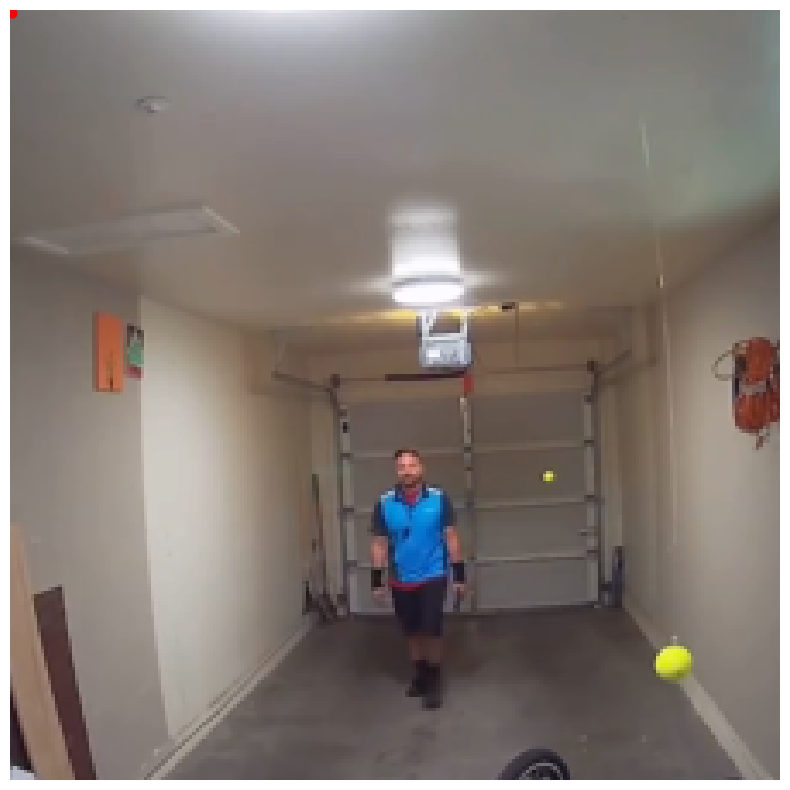

this is what the output looks like :  [[ 1.04380473e-01  1.03938304e-01 -1.53199226e-01]
 [-2.04978019e-01  1.49239779e-01  3.91444504e-01]
 [ 2.10870147e-01 -3.30587536e-01  2.67791692e-02]
 [ 1.05476983e-01  4.39008810e-02  2.56422579e-01]
 [-5.25551438e-02  2.98855491e-02  4.87600043e-02]
 [-1.26662910e-01  1.53163061e-01  1.31889246e-04]
 [ 8.28101337e-02 -9.44277458e-03 -2.20429488e-02]
 [ 4.17196602e-01  1.21980943e-01  9.75072533e-02]
 [-1.49092108e-01  2.60673523e-01  5.65369129e-02]
 [ 1.95434511e-01 -1.20736793e-01 -1.80292472e-01]
 [-4.91036028e-02  5.07153869e-02  5.34887165e-02]
 [ 1.70735061e-01  2.26275191e-01 -7.75537714e-02]
 [ 9.57129896e-02  2.01098070e-01  1.60961404e-01]
 [ 3.83183137e-02  1.28090128e-01  1.34738863e-01]
 [ 1.20313324e-01 -1.09284937e-01  1.92672789e-01]
 [ 3.68327588e-01  8.59354138e-02  3.87441404e-02]
 [ 3.81174684e-01  2.69253254e-01 -2.40838692e-01]]
this is the length of keypoints :   3


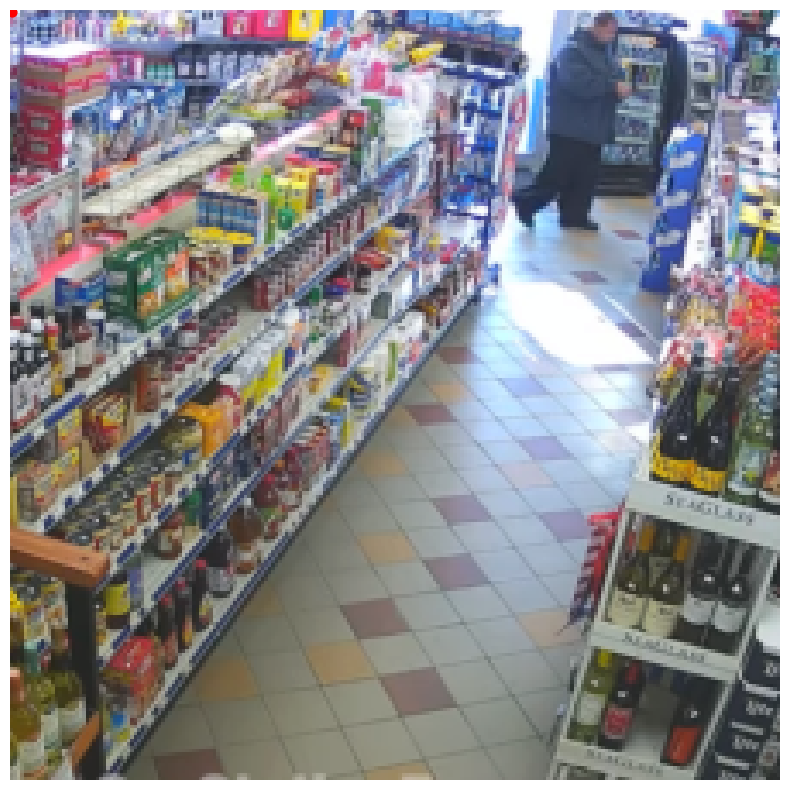

this is what the output looks like :  [[-8.73990729e-02  6.10311814e-02  1.42955303e-01]
 [-4.69823442e-02 -7.24659041e-02 -4.99794111e-02]
 [ 1.27296895e-04  3.11161466e-02 -6.88499361e-02]
 [ 4.81196120e-02  5.98331019e-02 -1.61238968e-01]
 [ 1.72838315e-01 -4.26318571e-02 -8.62887427e-02]
 [ 2.09982440e-01  9.59547907e-02 -5.73338717e-02]
 [ 4.81399000e-02  4.25788611e-02 -1.14788517e-01]
 [ 5.47073036e-02  3.58145013e-02 -1.09930992e-01]
 [ 1.13065764e-01  1.52028173e-01  2.20243409e-02]
 [ 1.39292508e-01 -2.07920566e-01 -1.61795944e-01]
 [-7.86386952e-02  1.23805813e-01  4.31736186e-02]
 [ 3.67167369e-02  8.96769688e-02  2.08011940e-01]
 [-1.02559537e-01  1.60842240e-01  5.96331209e-02]
 [ 1.14207625e-01  5.92813268e-02  3.30180824e-02]
 [ 4.42449860e-02  1.61077874e-03  1.66378945e-01]
 [ 1.29196346e-01 -3.29545327e-02  9.21606869e-02]
 [-5.25365658e-02  1.39257312e-01 -7.84041882e-02]]
this is the length of keypoints :   3


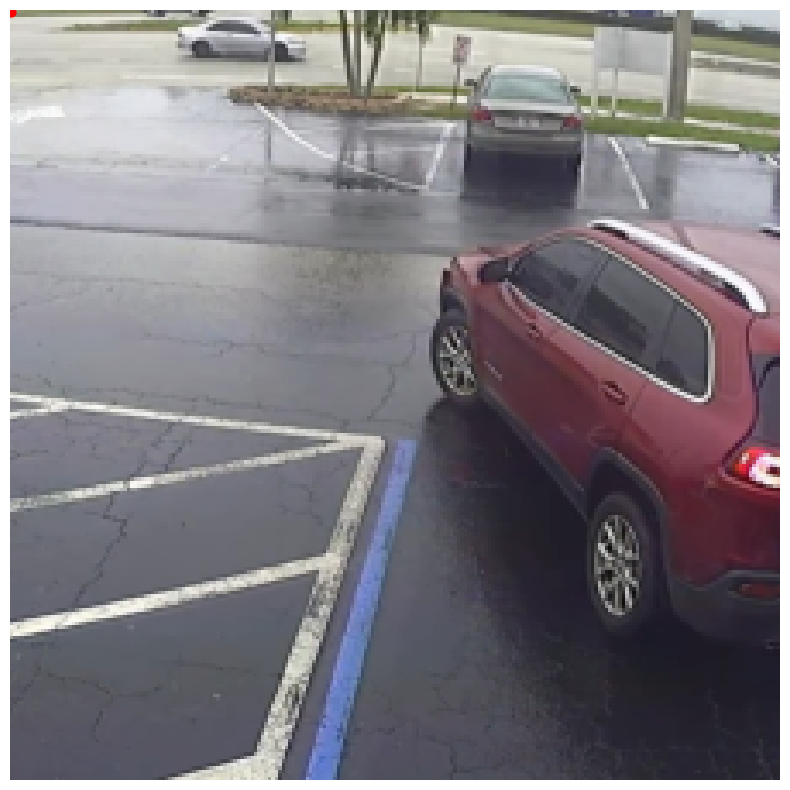

this is what the output looks like :  [[-1.36149690e-01 -3.17969918e-02  1.86146945e-01]
 [-1.82980701e-01 -1.00173019e-02  9.46239568e-04]
 [ 8.59454051e-02 -3.52235511e-05 -1.08614527e-02]
 [ 1.06714062e-01  1.32166743e-01  5.09632565e-02]
 [ 7.59198964e-02 -9.50809270e-02  2.18630750e-02]
 [ 3.45154852e-02  7.34768808e-02  9.43406150e-02]
 [-5.34198768e-02  9.09737721e-02 -6.66837841e-02]
 [-2.51452699e-02  5.56632131e-02 -9.09298509e-02]
 [ 7.93447942e-02  1.81498021e-01 -1.69290707e-01]
 [ 4.62826490e-02 -5.86340874e-02 -3.32755670e-02]
 [-2.73259468e-02 -3.32705230e-02  1.04490846e-01]
 [ 1.18876584e-01  2.32161969e-01  5.91609254e-02]
 [ 1.05321936e-01 -5.22881933e-02  1.06662400e-01]
 [ 1.33660257e-01 -1.14363417e-01 -1.96629260e-02]
 [ 6.35674819e-02 -3.15835848e-02  1.18669458e-01]
 [-1.75700560e-02  9.58601534e-02  2.11527348e-01]
 [ 2.23499566e-01 -4.80854511e-03 -2.84312814e-02]]
this is the length of keypoints :   3


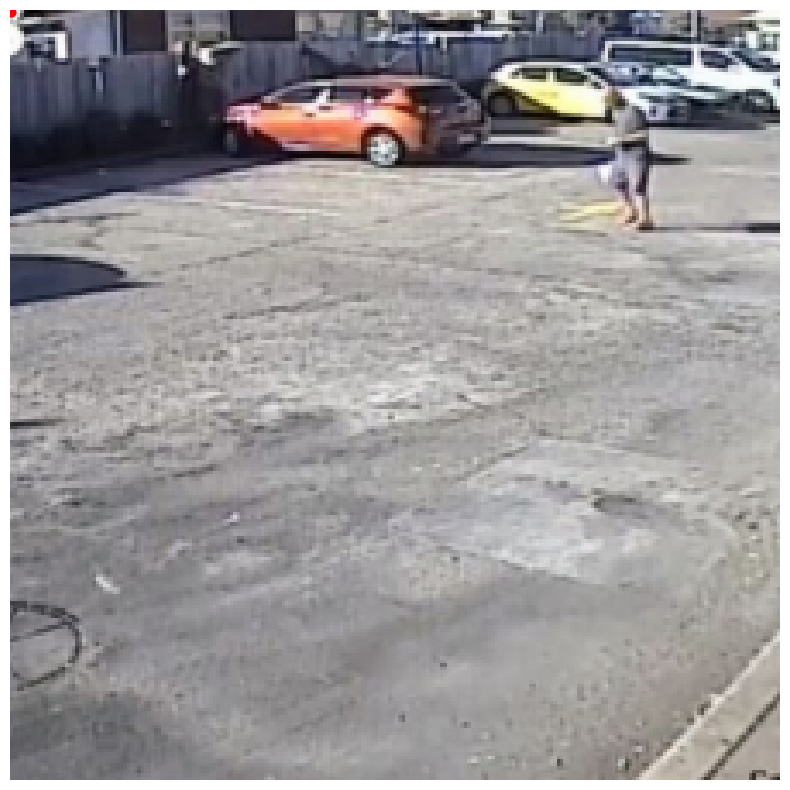

this is what the output looks like :  [[-0.02067242 -0.05172986  0.07204246]
 [-0.02673956  0.21488693  0.19826761]
 [-0.06912297 -0.08652416 -0.1988327 ]
 [-0.02634584  0.12614654  0.15524782]
 [ 0.35161752  0.12981275 -0.06458443]
 [-0.0478631   0.18978491  0.04498801]
 [ 0.29660338  0.02072239 -0.14573365]
 [ 0.2650276   0.12891692 -0.0846882 ]
 [ 0.16440058  0.18848482  0.11663105]
 [ 0.2574149   0.13772734 -0.00627643]
 [ 0.1597699  -0.02741461  0.37308246]
 [ 0.2577922   0.20840667  0.04513245]
 [ 0.325815    0.03472662  0.08523247]
 [ 0.05089628 -0.23074618  0.21549596]
 [ 0.29446113  0.1478878   0.28333595]
 [ 0.3363811   0.20482002 -0.03646621]
 [ 0.4431547   0.24423045  0.04100668]]
this is the length of keypoints :   3


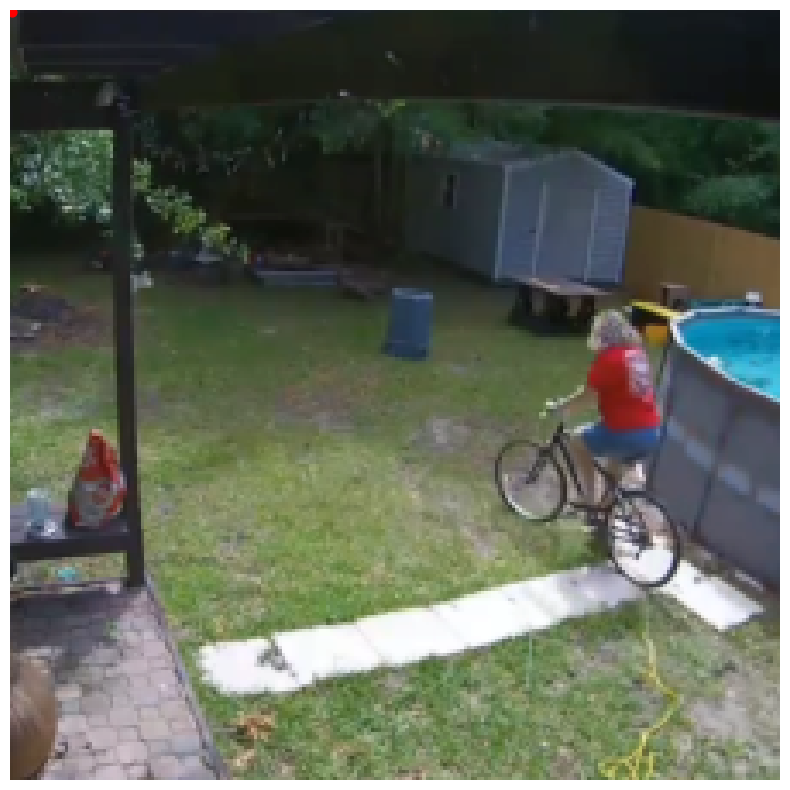

this is what the output looks like :  [[ 0.01187734 -0.19377369  0.07537741]
 [-0.05481646  0.45527753  0.12924261]
 [ 0.10056275  0.04131795 -0.03275284]
 [ 0.14846468  0.16029938  0.01303716]
 [ 0.01978707  0.0100508  -0.08235496]
 [ 0.09328628  0.21189134 -0.1397403 ]
 [-0.01430094 -0.11716855 -0.08100638]
 [ 0.05382438  0.05053108 -0.01284982]
 [ 0.26446715  0.24142389  0.21529856]
 [ 0.51162463  0.03417583 -0.0264738 ]
 [ 0.01466364  0.070372    0.25617933]
 [ 0.35527843  0.12095226 -0.01717827]
 [-0.21715923  0.21858591 -0.24307875]
 [ 0.32325354 -0.20946701  0.2761537 ]
 [-0.06504379 -0.1204676   0.59084004]
 [ 0.12151724  0.1357623   0.02942713]
 [ 0.2672537   0.04237618  0.04066361]]
this is the length of keypoints :   3


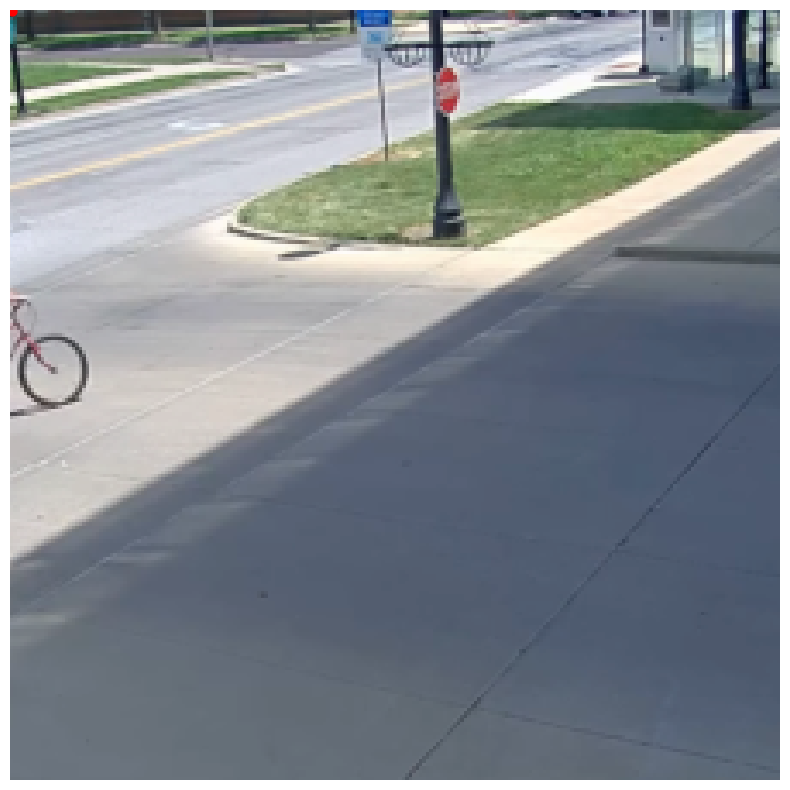

this is what the output looks like :  [[-0.05493446 -0.11254487  0.05547357]
 [-0.08789653 -0.021695    0.23495266]
 [-0.09978636 -0.11157069  0.04880913]
 [-0.0573853   0.20174621  0.13719371]
 [ 0.06423257 -0.150505   -0.02637665]
 [ 0.08488807  0.01695368  0.24007718]
 [ 0.12603903 -0.11697491 -0.13711274]
 [ 0.13829307  0.06341264 -0.19184561]
 [ 0.03402724 -0.01686574 -0.04392477]
 [ 0.04180205  0.02935491  0.11892098]
 [ 0.2232603   0.13808875  0.06234494]
 [ 0.10465733 -0.06161151 -0.06113441]
 [-0.04224018  0.29604712  0.13218437]
 [-0.02234564 -0.02742027 -0.05115854]
 [-0.05538057 -0.12007509  0.17622721]
 [-0.0172119   0.19388245 -0.10906497]
 [ 0.18748285  0.08634725  0.07291701]]
this is the length of keypoints :   3


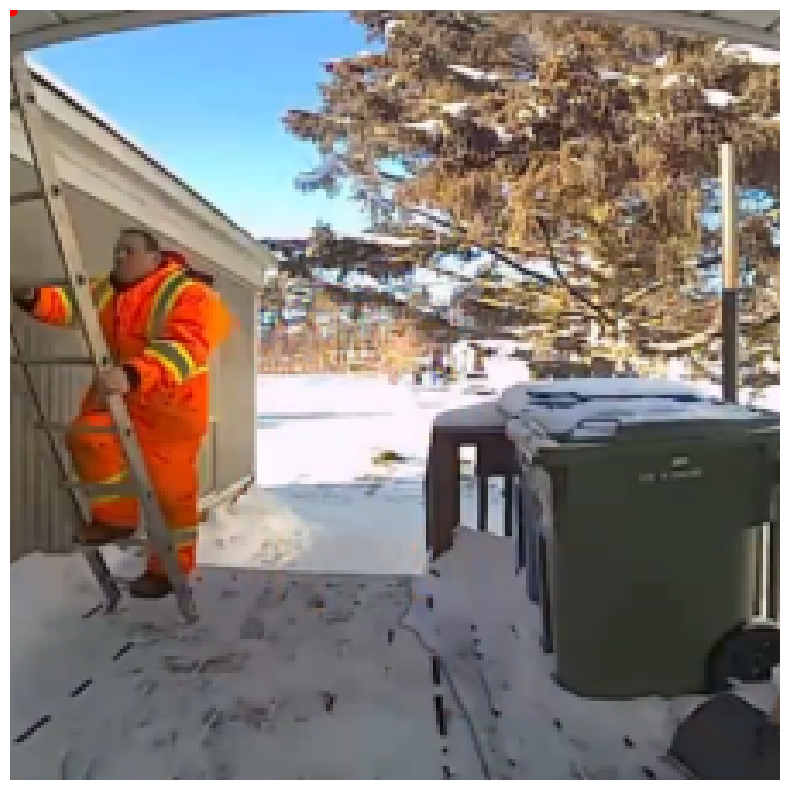

this is what the output looks like :  [[ 0.06251997  0.29554397  0.08137343]
 [-0.15975101  0.16632098  0.21242118]
 [ 0.01872579  0.00119932 -0.10202968]
 [ 0.1054187   0.14938653  0.01867087]
 [ 0.0179633  -0.00946745 -0.08918677]
 [-0.05009349  0.2969513   0.0469921 ]
 [ 0.05423159 -0.03631158 -0.05438802]
 [ 0.0482581   0.05925064 -0.20964123]
 [-0.11209225  0.00360961 -0.1318448 ]
 [ 0.27019873  0.12448979  0.11955692]
 [ 0.14608681  0.08292455  0.06127525]
 [ 0.05537286  0.22003384 -0.10051967]
 [ 0.20098564  0.3098308   0.026751  ]
 [ 0.07146502 -0.1597606  -0.00831179]
 [ 0.10178483  0.04519774  0.01336496]
 [-0.07166346 -0.0362161   0.26503947]
 [ 0.18053955 -0.041138   -0.12352763]]
this is the length of keypoints :   3


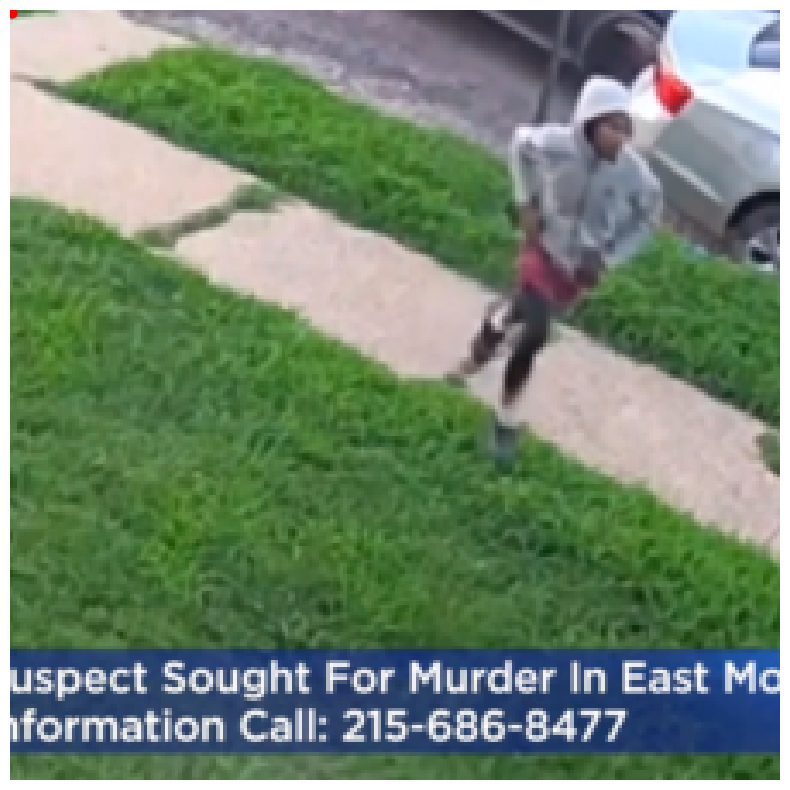

this is what the output looks like :  [[-0.06909458  0.11985798  0.01985416]
 [-0.11805034  0.04281197  0.19751087]
 [ 0.08168504 -0.01861574  0.01007859]
 [ 0.07838942  0.03960631  0.10339269]
 [-0.01055516  0.01969009  0.00109504]
 [-0.08435273 -0.19427738  0.24679868]
 [ 0.02673147  0.16328211 -0.05929701]
 [ 0.21427904  0.18840522  0.12072873]
 [-0.02876088  0.03907118  0.1924931 ]
 [ 0.22121862  0.02872311 -0.23190288]
 [ 0.00741253  0.09018148  0.0683693 ]
 [ 0.1741439  -0.06285187  0.08118473]
 [ 0.08230769  0.01911301  0.11234222]
 [ 0.33043888 -0.15098229  0.11399474]
 [ 0.16858803  0.00908519  0.06718885]
 [-0.07804836  0.02808587  0.01764031]
 [ 0.26258922  0.09431174  0.18752833]]
this is the length of keypoints :   3


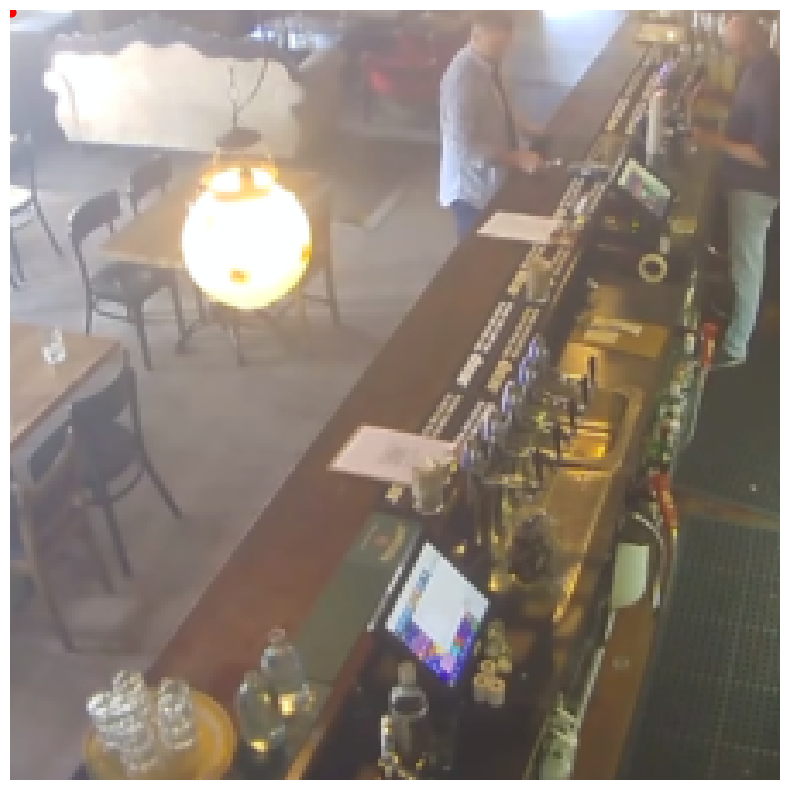

this is what the output looks like :  [[ 0.0724941  -0.28143653  0.24375887]
 [ 0.0033316   0.03504209  0.3956643 ]
 [ 0.16894186 -0.00141139 -0.03628749]
 [ 0.02034875  0.18448012  0.29106766]
 [-0.08724225  0.18279876 -0.02030606]
 [-0.29709482 -0.1970518   0.16707844]
 [-0.21763046 -0.09574941  0.09141906]
 [-0.0290219   0.21747088 -0.18429673]
 [ 0.12444992  0.07941242 -0.0855811 ]
 [ 0.02755757  0.2759173   0.02592348]
 [ 0.20746492 -0.02698097  0.0240869 ]
 [ 0.02220194  0.22177948 -0.03346876]
 [-0.03798366  0.06556015  0.12051756]
 [ 0.16163373 -0.06817222  0.09154981]
 [ 0.02978116 -0.19617477  0.03175673]
 [-0.09723785  0.07942922  0.11567588]
 [ 0.21531512  0.33583635 -0.01787175]]
this is the length of keypoints :   3


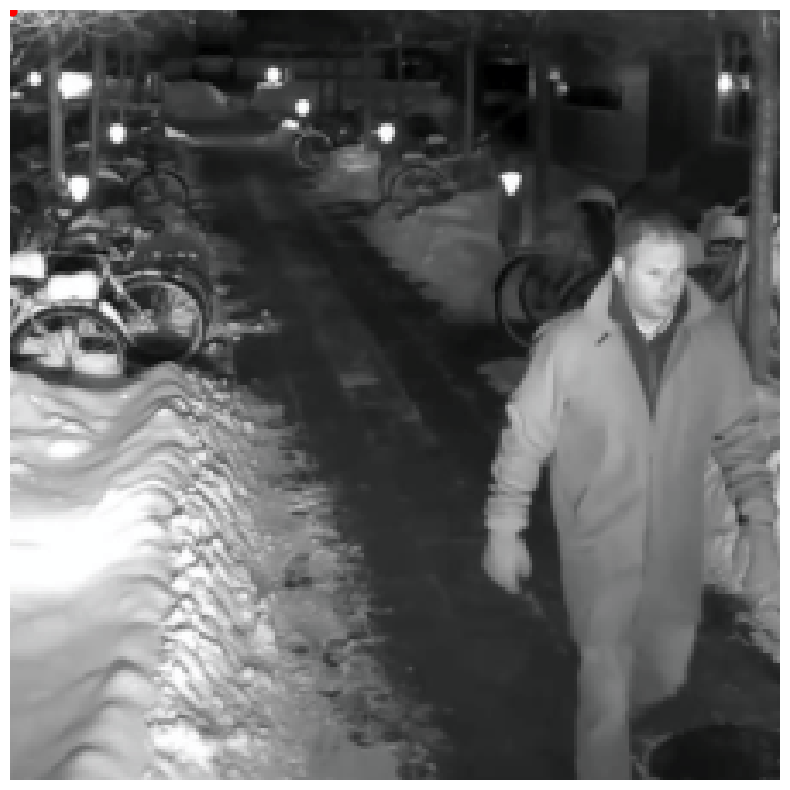

this is what the output looks like :  [[-0.08910854 -0.1013779   0.04881473]
 [-0.13562565  0.1120039   0.15901916]
 [ 0.11768161 -0.03766815  0.18608393]
 [ 0.08984318  0.15989904 -0.16934724]
 [ 0.03343854 -0.16345417 -0.3143103 ]
 [-0.215179    0.06737941  0.08228546]
 [ 0.10653596  0.07143365 -0.27840948]
 [ 0.00225875  0.20794395  0.07011019]
 [ 0.10333531  0.23974217  0.16515683]
 [ 0.29122284  0.12440892 -0.11838566]
 [ 0.20150337  0.23318943  0.24155626]
 [ 0.23807026  0.3074732   0.05339539]
 [ 0.06199724  0.1766609  -0.20016938]
 [ 0.10323374  0.00294701  0.09523883]
 [ 0.29481253  0.24010572 -0.09080326]
 [ 0.33199462  0.22033463 -0.11359951]
 [ 0.32741198  0.27166313 -0.05103763]]


In [7]:
import json
import os
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights

# Custom dataset class
class KeypointDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.keypoints_dict = {ann['image_id']: ann['keypoints'] for ann in self.annotations}

        # Pre-check for readable images
        self.valid_images = []
        for img_info in self.images:
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            if os.path.exists(img_path) and cv2.imread(img_path) is not None:
                self.valid_images.append(img_info)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        keypoints = self.keypoints_dict.get(img_info['id'], [])
        keypoints = np.array(keypoints, dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        keypoints = keypoints.reshape(-1)  # Flatten the keypoints array
        return image, keypoints

# Define data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
annotations_file = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/CCTVAnnotations.json'
img_dir = '/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/Images'

test_dataset = KeypointDataset(annotations_file, img_dir, transform=data_transforms)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the final layer to output the correct number of keypoints (each keypoint has x, y, v)
num_keypoints = 17  # Number of keypoints
model.fc = nn.Linear(model.fc.in_features, num_keypoints * 3)

# Load the trained model weights
model.load_state_dict(torch.load('/home/sarim.hashmi/Downloads/datasets_for_OD/pose_estimation/best_model.pth'))
model = model.to(device)
model.eval()

# Function to visualize predictions
def visualize_predictions(dataloader, model, num_images=10):
    images_so_far = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.cpu().numpy().reshape(-1, 3)
            print("this is what the output looks like : ",outputs)

            for i in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return

                images_so_far += 1
                image = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
                image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

                keypoints = outputs[i]

                plt.figure(figsize=(10, 10))
                plt.imshow(image)

                for j in range(0, len(keypoints), 3):
                    x, y, v = keypoints[j], keypoints[j + 1], keypoints[j + 2]
                    # if v > 0:  # visibility flag is greater than 0, draw the keypoint
                    plt.scatter(x, y, c='red', s=40)
                    print("this is the length of keypoints :  ",len(keypoints))

                plt.axis('off')
                plt.show()

# Visualize predictions on test images
visualize_predictions(dataloader, model, num_images=10)
